# Predicting Weeks on Billboard for Rolling Stone's Top 500 Albums


## Summary
Here, we attempt to build a regression model using the k-nearest neighbors (kNN) algorithm to predict the number of weeks an album spends on the Billboard chart (weeks_on_billboard) based on characteristics such as release_year, peak_billboard_position, and spotify_popularity. This model could help music industry analysts, artists, and record labels understand the factors that contribute to an album’s longevity on the chart and make informed decisions about marketing and production strategies.

Our current model has a prediction error, as measured by the Root Mean Squared Error (RMSE), of approximately 72.16 weeks. This model has room for improvement, given that the weeks_on_billboard values has an Interquartile range of about 37 weeks.

The data used to build this model comes from Rolling Stone's rankings dataset, which includes information about album releases, chart performance, and artist details. The dataset was sourced from [TidyTuesday](https://github.com/rfordatascience/tidytuesday/blob/main/data/2024/2024-05-07/rolling_stone.csv).

## Introduction:
The Billboard chart is a widely recognized measure of an album’s commercial success. Understanding the factors that contribute to an album’s longevity on the chart can provide valuable insights for artists, record labels, and music industry analysts. For example:

Artists: Can use this information to plan album releases and marketing strategies.

Record Labels: Can identify trends and allocate resources effectively.

Analysts: Can predict the potential success of new albums based on historical data.

In this project, we aim to answer the following question: Can we use characteristics of an album (e.g., release year, peak chart position, Spotify popularity) to predict how long it will stay on the Billboard chart?

To answer this question, we used a k-nearest neighbors (kNN) regression model and data from Rolling Stone's rankings. We found that our model has a prediction error of approximately 72.16 weeks, which is reasonable given the variability in the data. However, there is room for improvement, as the model explains 18.67% of the variability in weeks_on_billboard.

# Methods & Results:
## Data
The dataset used in this project contains information about Rolling Stone's Top 500 Albums, including characteristics such as release_year, peak_billboard_position, spotify_popularity, genre, and weeks_on_billboard. The data was sourced from TidyTuesday. Using domain expertise and exploartory analysis, we chose to focus on the following predictor variables:

Table 1. Predictor variables used for analysis, chosen for their utility by domain expertise.

| Predictor  | Description |
|----------|----------|
| release_year | The year the album was released. | 
| peak_billboard_position | The highest position the album reached on the Billboard chart. |
| spotify_popularity | A measure of the album’s popularity on Spotify (0–100 scale). |
| artist_gender | The artist's gender |



### Importing the dataset from Github

In [1]:
url <- 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-05-07/rolling_stone.csv'
download.file(url, 'data/rolling_stone.csv')
rollingstone <- readr::read_csv('data/rolling_stone.csv')

Rows: 691 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): sort_name, clean_name, album, genre, type, spotify_url, artist_gen...
dbl (13): rank_2003, rank_2012, rank_2020, differential, release_year, weeks...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Preliminary Analysis

### Loading the necessary libraries

In [2]:
library(tidyr)
library(dplyr)
library(readr)
library(ggplot2)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




### Wrangling

The dataset used in this project was cleaned and prepared for analysis through several steps. First, numerical columns which had a large number of missing values(25% of total) and were poorly correlated as found in the EDA later were removed. Categorical variables like sort_name, clean_name, album(name), spotify_url, etc. were removed, as they were not relevant to the analysis, and it would be difficult to use these variables as they are close to unique identifiers. Next, missing values were handled: the genre and type columns were imputed using the most frequent strategy, and the weeks_on_billboard column was imputed using the mean strategy, as removing these would have significantly skewed the analysis. Rows with missing values in other columns were dropped to ensure a complete dataset. Finally, all numeric predictors were scaled to ensure equal weighting in the kNN algorithm. These steps resulted in a clean, analysis-ready dataset.

In [3]:
set.seed(123)  # For reproducibility

# 1. Removing duplicates
rolling_stone_distinct <- distinct(rollingstone)

# 2. Inspecting data
head(rolling_stone_distinct)  # View the first few rows
str(rolling_stone_distinct)   # Check the structure of the data
summary(rolling_stone_distinct) # Summary statistics

# 3. Check for missing values
colSums(is.na(rolling_stone_distinct))

sort_name,clean_name,album,rank_2003,rank_2012,rank_2020,differential,release_year,genre,type,⋯,peak_billboard_position,spotify_popularity,spotify_url,artist_member_count,artist_gender,artist_birth_year_sum,debut_album_release_year,ave_age_at_top_500,years_between,album_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
"Sinatra, Frank",Frank Sinatra,In the Wee Small Hours,100,101,282,-182,1955,Big Band/Jazz,Studio,⋯,2,48,spotify:album:3GmwKB1tgPZgXeRJZSm9WX,1,Male,1915,1946,40,9,3GmwKB1tgPZgXeRJZSm9WX
"Diddley, Bo",Bo Diddley,Bo Diddley / Go Bo Diddley,214,216,455,-241,1955,Rock n' Roll/Rhythm & Blues,Studio,⋯,201,50,spotify:album:1cbtDEwxCjMhglb49OgNBR,1,Male,1928,1955,27,0,1cbtDEwxCjMhglb49OgNBR
"Presley, Elvis",Elvis Presley,Elvis Presley,55,56,332,-277,1956,Rock n' Roll/Rhythm & Blues,Studio,⋯,1,58,spotify:album:7GXP5OhYyPVLmcVfO9Iqin,1,Male,1935,1956,21,0,7GXP5OhYyPVLmcVfO9Iqin
"Sinatra, Frank",Frank Sinatra,Songs for Swingin' Lovers!,306,308,NA,-195,1956,Big Band/Jazz,Studio,⋯,2,62,spotify:album:4kca7vXd1Wo5GE2DMafvMc,1,Male,1915,1946,41,10,4kca7vXd1Wo5GE2DMafvMc
Little Richard,Little Richard,Here's Little Richard,50,50,227,-177,1957,NA,Studio,⋯,13,64,spotify:album:18tV6PLXYvVjsdOVk0S7M8,1,Male,1932,1957,25,0,18tV6PLXYvVjsdOVk0S7M8
Beyonce,Beyonce,Lemonade,NA,NA,32,469,2016,NA,Studio,⋯,1,73,spotify:album:7dK54iZuOxXFarGhXwEXfF,1,Female,1981,2003,35,13,7dK54iZuOxXFarGhXwEXfF


tibble [691 × 21] (S3: tbl_df/tbl/data.frame)
 $ sort_name               : chr [1:691] "Sinatra, Frank" "Diddley, Bo" "Presley, Elvis" "Sinatra, Frank" ...
 $ clean_name              : chr [1:691] "Frank Sinatra" "Bo Diddley" "Elvis Presley" "Frank Sinatra" ...
 $ album                   : chr [1:691] "In the Wee Small Hours" "Bo Diddley / Go Bo Diddley" "Elvis Presley" "Songs for Swingin' Lovers!" ...
 $ rank_2003               : num [1:691] 100 214 55 306 50 NA NA 421 NA 12 ...
 $ rank_2012               : num [1:691] 101 216 56 308 50 NA 451 420 NA 12 ...
 $ rank_2020               : num [1:691] 282 455 332 NA 227 32 33 NA 68 31 ...
 $ differential            : num [1:691] -182 -241 -277 -195 -177 469 468 -80 433 -19 ...
 $ release_year            : num [1:691] 1955 1955 1956 1956 1957 ...
 $ genre                   : chr [1:691] "Big Band/Jazz" "Rock n' Roll/Rhythm & Blues" "Rock n' Roll/Rhythm & Blues" "Big Band/Jazz" ...
 $ type                    : chr [1:691] "Studio" "Studio" 

  sort_name          clean_name           album             rank_2003    
 Length:691         Length:691         Length:691         Min.   :  1.0  
 Class :character   Class :character   Class :character   1st Qu.:125.8  
 Mode  :character   Mode  :character   Mode  :character   Median :250.5  
                                                          Mean   :250.5  
                                                          3rd Qu.:375.2  
                                                          Max.   :500.0  
                                                          NA's   :191    
   rank_2012       rank_2020      differential      release_year 
 Min.   :  1.0   Min.   :  1.0   Min.   :-501.00   Min.   :1955  
 1st Qu.:125.8   1st Qu.:125.8   1st Qu.:-137.50   1st Qu.:1971  
 Median :250.5   Median :250.5   Median :  -8.00   Median :1979  
 Mean   :250.5   Mean   :250.5   Mean   : -12.32   Mean   :1983  
 3rd Qu.:375.2   3rd Qu.:375.2   3rd Qu.: 106.00   3rd Qu.:1994  
 Max.   :500

sort_name               clean_name                    album 
                       0                        0                        0 
               rank_2003                rank_2012                rank_2020 
                     191                      191                      191 
            differential             release_year                    genre 
                       0                        0                      164 
                    type       weeks_on_billboard  peak_billboard_position 
                       0                      119                        0 
      spotify_popularity              spotify_url      artist_member_count 
                      37                       36                        5 
           artist_gender    artist_birth_year_sum debut_album_release_year 
                       5                        5                        5 
      ave_age_at_top_500            years_between                 album_id 
                       5                        5                        0

In [4]:
# 4. Drop irrelevant columns(domain knowledge and EDA)
columns_to_drop <- c("rank_2003", "rank_2012", "rank_2020", "spotify_url", "sort_name", "clean_name", "album_id", "album")
rolling_stone_cleaned <- rolling_stone_distinct  %>%
  select(-all_of(columns_to_drop))

# 5. Impute missing values in 'genre' with the most frequent value
most_frequent_genre <- names(sort(table(rolling_stone_cleaned$genre), decreasing = TRUE))[1]
rolling_stone_cleaned <- rolling_stone_cleaned %>%
  mutate(genre = ifelse(is.na(genre), most_frequent_genre, genre))

# 6. Check for missing values in 'genre'
sum(is.na(rolling_stone_cleaned$genre))

# 7. Impute missing values in 'weeks_on_billboard' with the mean
mean_weeks <- mean(rolling_stone_cleaned$weeks_on_billboard, na.rm = TRUE)
rolling_stone_cleaned <- rolling_stone_cleaned %>%
  mutate(weeks_on_billboard = ifelse(is.na(weeks_on_billboard), mean_weeks, weeks_on_billboard))

# 8. Check for missing values in 'weeks_on_billboard'
sum(is.na(rolling_stone_cleaned$weeks_on_billboard))

# 9. Drop rows with missing values in other columns
rolling_stone_cleaned <- rolling_stone_cleaned %>%
  drop_na()

# 10. Check for missing values in the entire dataset
colSums(is.na(rolling_stone_cleaned))

# 11. Inspect the cleaned dataset
head(rolling_stone_cleaned)
dim(rolling_stone_cleaned)

[1] 0

[1] 0

differential             release_year                    genre 
                       0                        0                        0 
                    type       weeks_on_billboard  peak_billboard_position 
                       0                        0                        0 
      spotify_popularity      artist_member_count            artist_gender 
                       0                        0                        0 
   artist_birth_year_sum debut_album_release_year       ave_age_at_top_500 
                       0                        0                        0 
           years_between 
                       0

differential,release_year,genre,type,weeks_on_billboard,peak_billboard_position,spotify_popularity,artist_member_count,artist_gender,artist_birth_year_sum,debut_album_release_year,ave_age_at_top_500,years_between
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
-182,1955,Big Band/Jazz,Studio,14.00000,2,48,1,Male,1915,1946,40,9
-241,1955,Rock n' Roll/Rhythm & Blues,Studio,64.27098,201,50,1,Male,1928,1955,27,0
-277,1956,Rock n' Roll/Rhythm & Blues,Studio,100.00000,1,58,1,Male,1935,1956,21,0
-195,1956,Big Band/Jazz,Studio,64.27098,2,62,1,Male,1915,1946,41,10
-177,1957,Punk/Post-Punk/New Wave/Power Pop,Studio,5.00000,13,64,1,Male,1932,1957,25,0
469,2016,Punk/Post-Punk/New Wave/Power Pop,Studio,87.00000,1,73,1,Female,1981,2003,35,13


[1] 653  13

### Train/Test Split and EDA

The data was partitioned into training (80%) and testing (20%) sets. The relationship between weeks_on_billboard and the predictor variables was visualized using scatter plots and boxplots to assess their utility for predictive modeling. Correlation was also used to assess the relationship betweent the response and the predictors.

In [5]:
# Training and testing split
set.seed(123)
sample_index <- sample(1:nrow(rolling_stone_cleaned), 0.8 * nrow(rolling_stone_cleaned))
train_data <- rolling_stone_cleaned[sample_index, ]
test_data <- rolling_stone_cleaned[-sample_index, ]

### Exploratory Data Analysis

[1] "differential"             "release_year"            
 [3] "weeks_on_billboard"       "peak_billboard_position" 
 [5] "spotify_popularity"       "artist_member_count"     
 [7] "artist_birth_year_sum"    "debut_album_release_year"
 [9] "ave_age_at_top_500"       "years_between"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


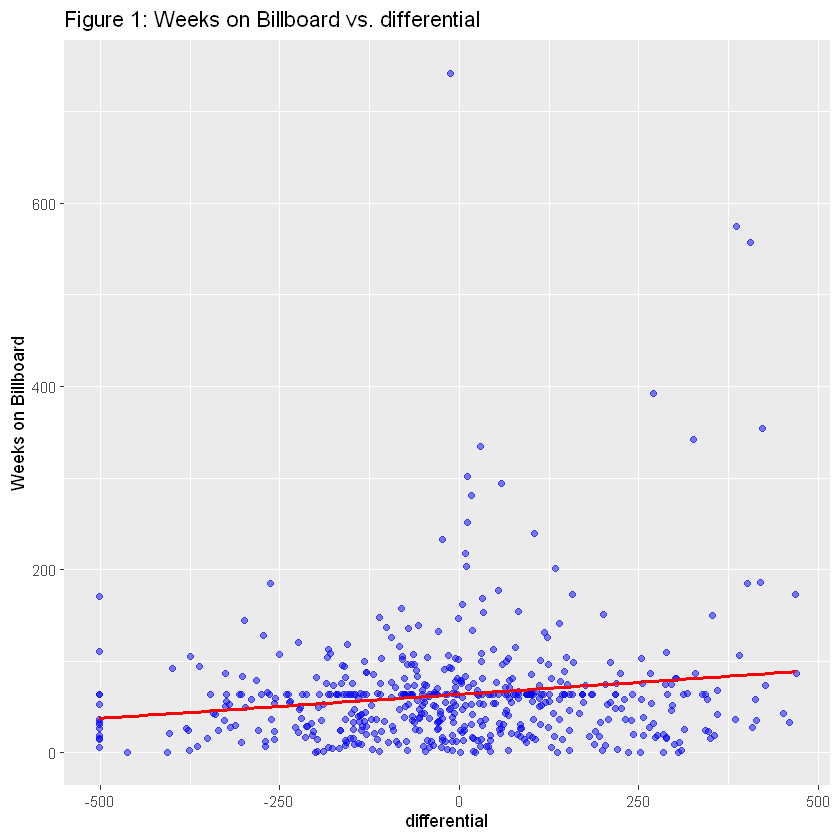

`geom_smooth()` using formula = 'y ~ x'


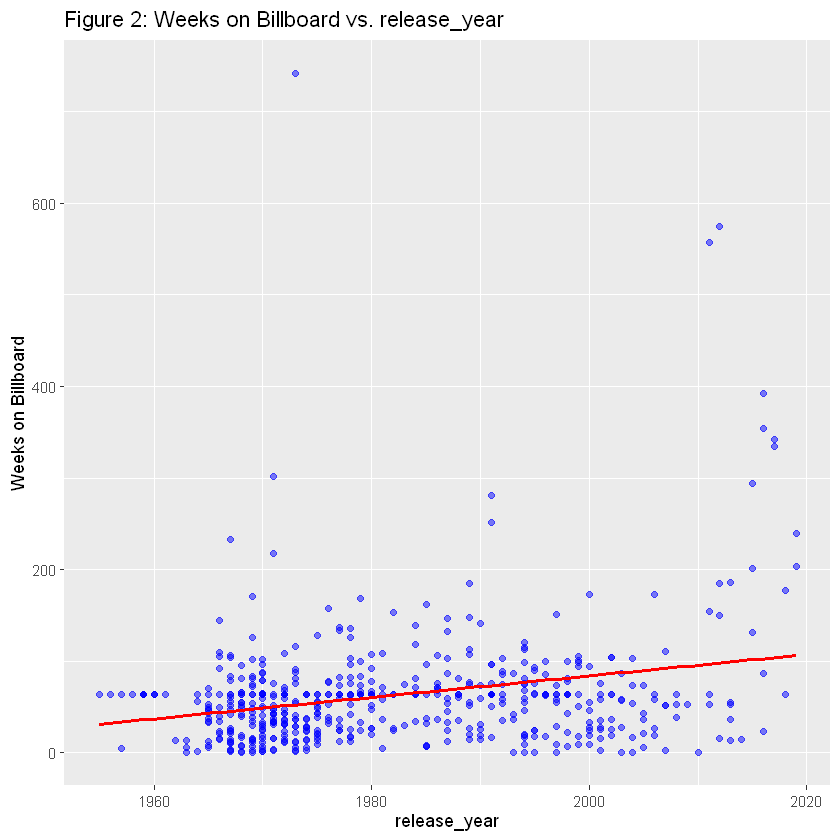

`geom_smooth()` using formula = 'y ~ x'


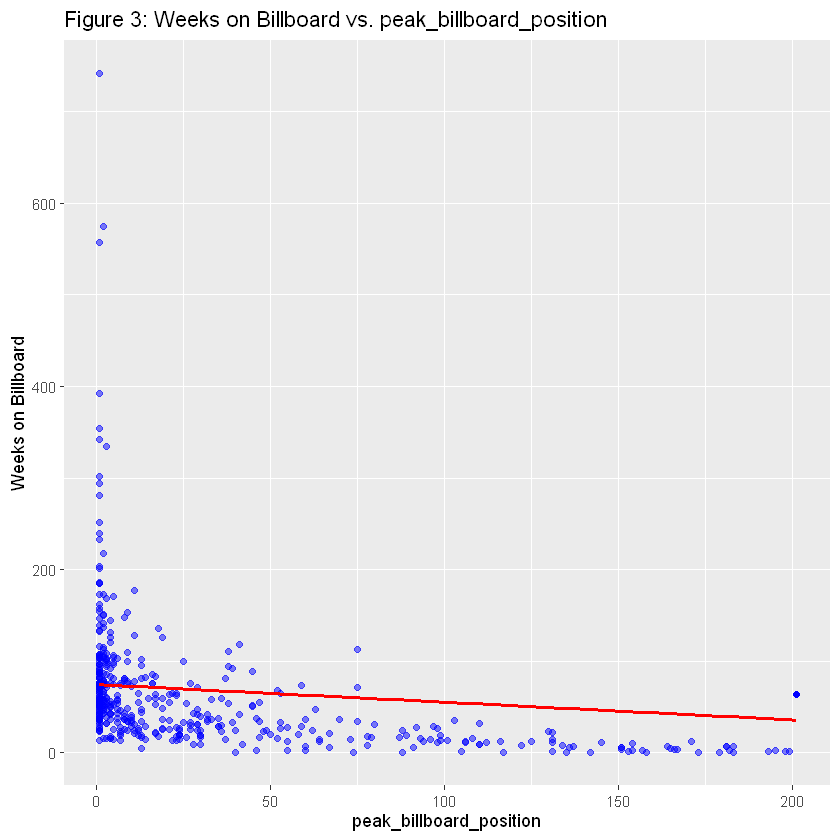

`geom_smooth()` using formula = 'y ~ x'


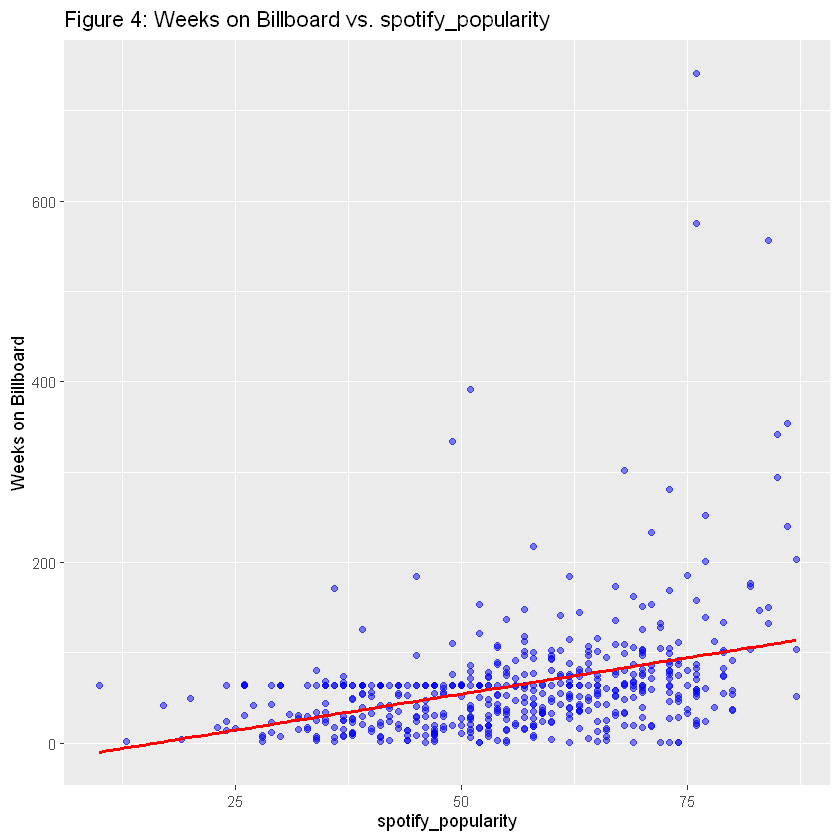

`geom_smooth()` using formula = 'y ~ x'


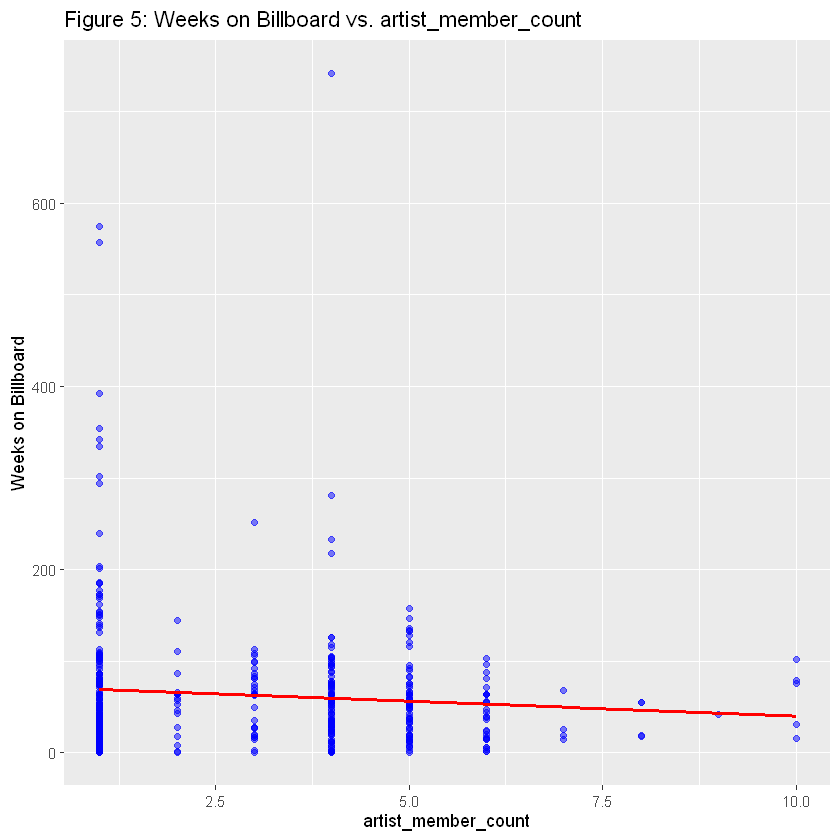

`geom_smooth()` using formula = 'y ~ x'


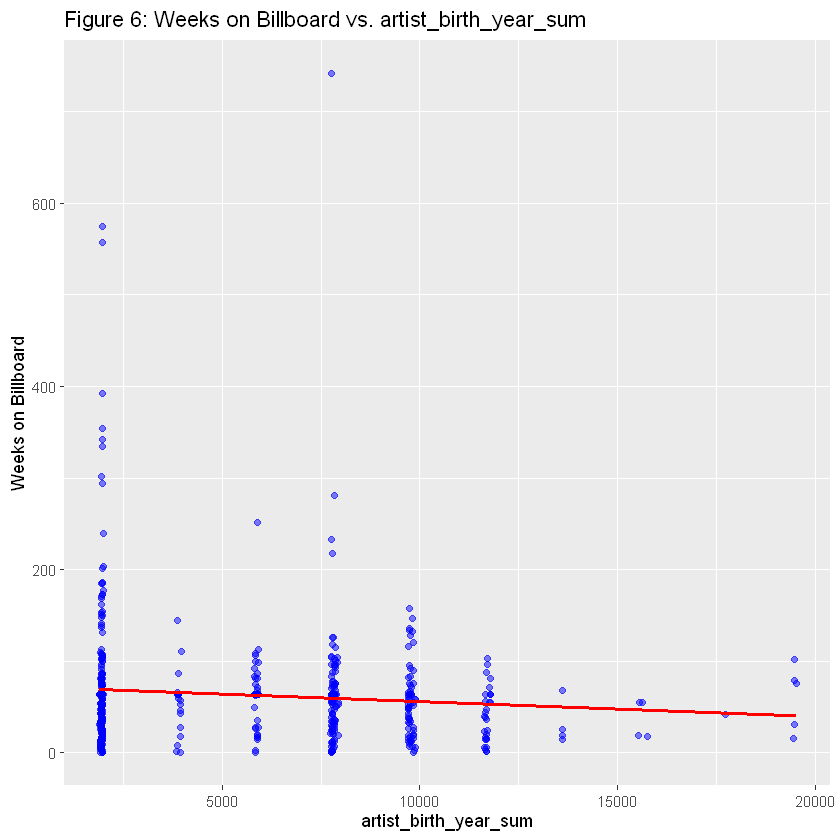

`geom_smooth()` using formula = 'y ~ x'


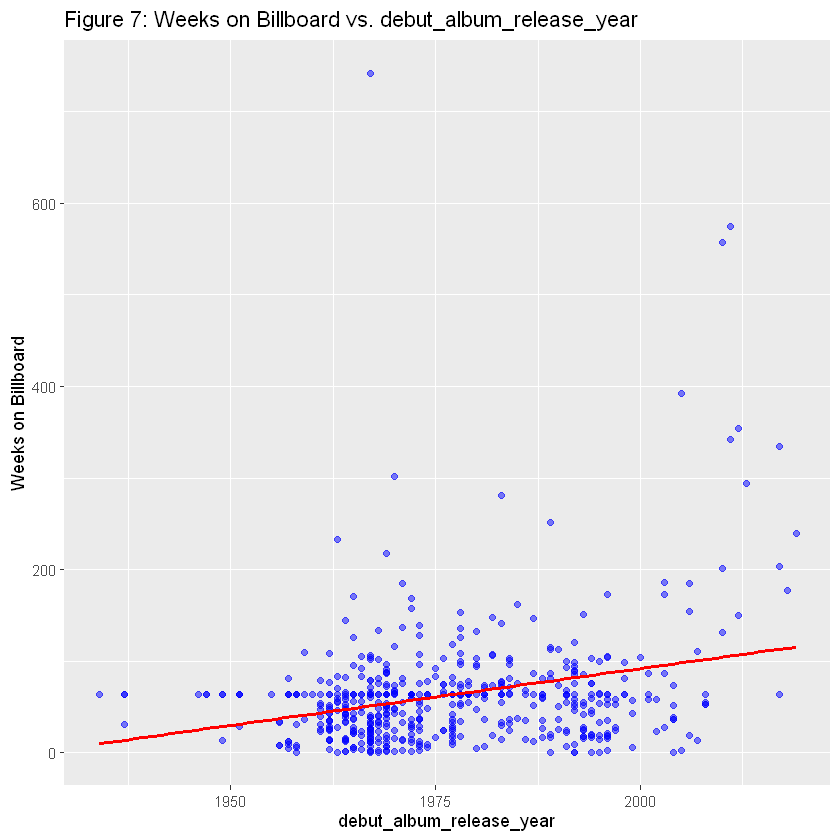

`geom_smooth()` using formula = 'y ~ x'


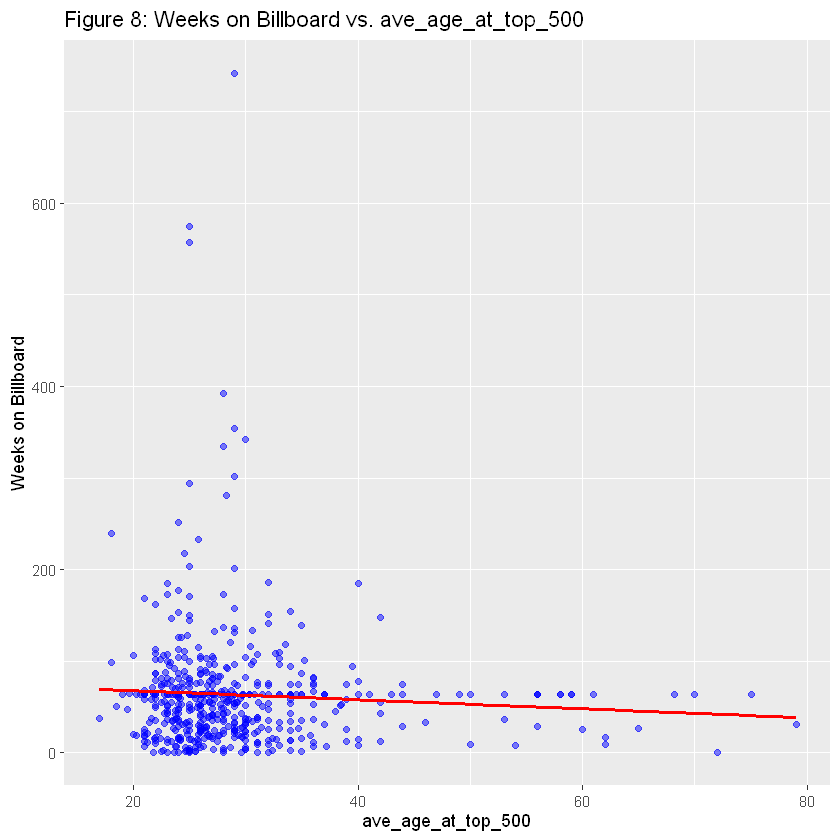

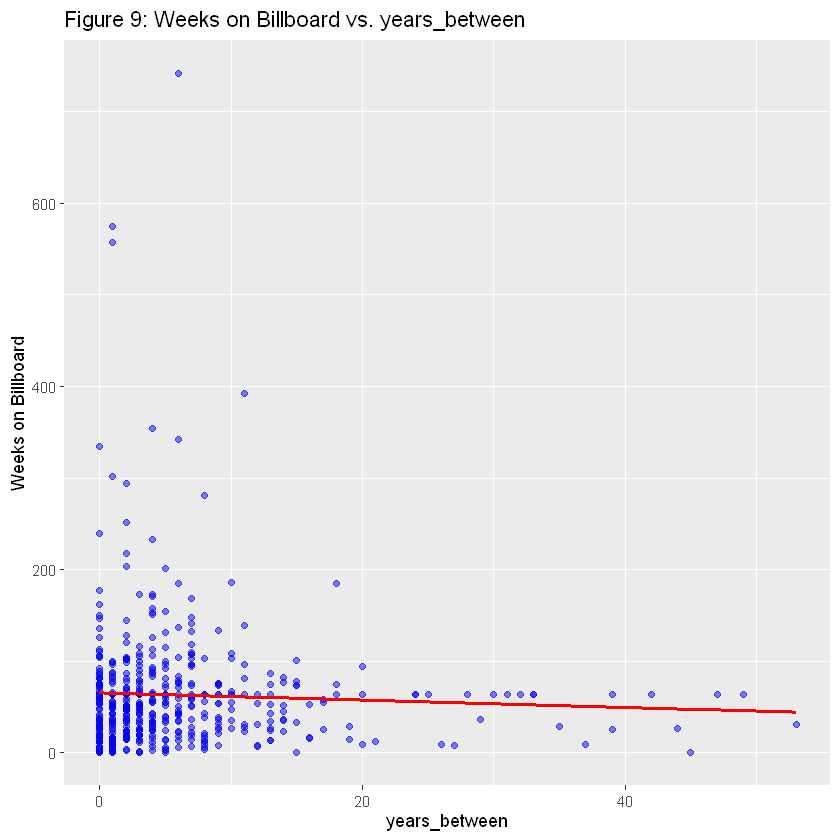

In [6]:
# Select all numeric variables
numeric_vars <- train_data %>%
  select(where(is.numeric))

# View the names of numeric variables
names(numeric_vars)

# Loop through all numeric variables (excluding the target variable)
num <- 1

for (var in names(numeric_vars)) {
  if (var != "weeks_on_billboard") {  # Skip the target variable
    # Create scatter plot
    p <- ggplot(train_data, aes(x = .data[[var]], y = weeks_on_billboard)) +
      geom_point(alpha = 0.5, color = "blue") +  # Add points with transparency
      geom_smooth(method = "lm", se = FALSE, color = "red") +  # Add a linear trendline
      labs(title = paste0("Figure ",num,": Weeks on Billboard vs. ", var), x = var, y = "Weeks on Billboard")
    # Print the plot
      num <- num +1
    print(p)
  }
}

In [7]:
# Compute correlations with the target variable
correlations <- train_data %>%
  select(where(is.numeric)) %>%
  cor() %>%
  as.data.frame() %>%
  select(weeks_on_billboard)

# View correlations
print(correlations)

                         weeks_on_billboard
differential                     0.15426503
release_year                     0.25512021
weeks_on_billboard               1.00000000
peak_billboard_position         -0.21583120
spotify_popularity               0.35723461
artist_member_count             -0.09530735
artist_birth_year_sum           -0.09410531
debut_album_release_year         0.27516748
ave_age_at_top_500              -0.06292870
years_between                   -0.04631483


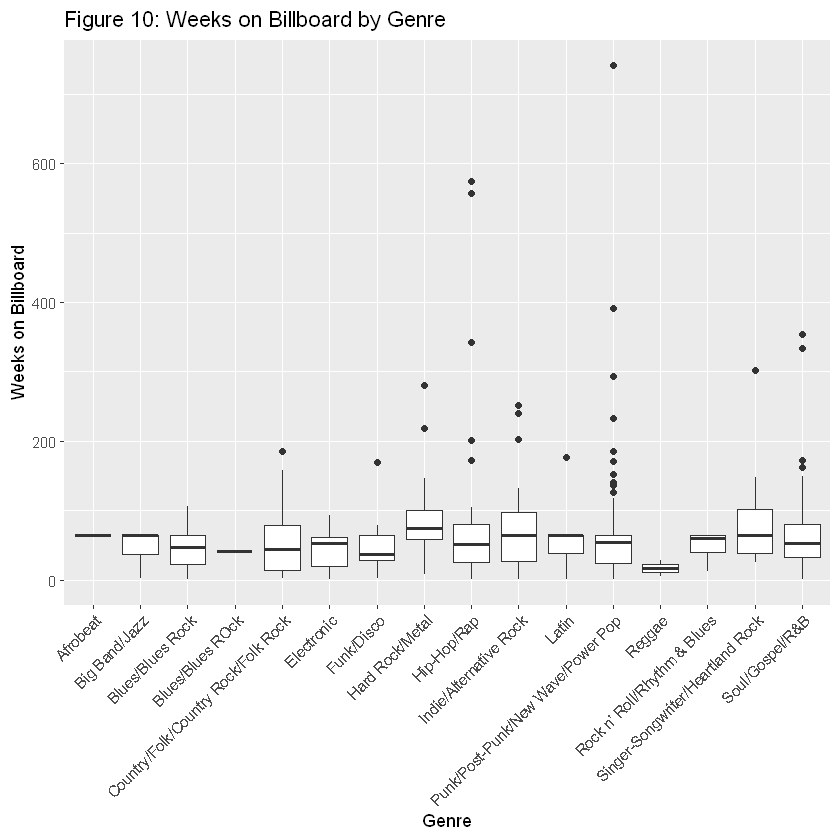

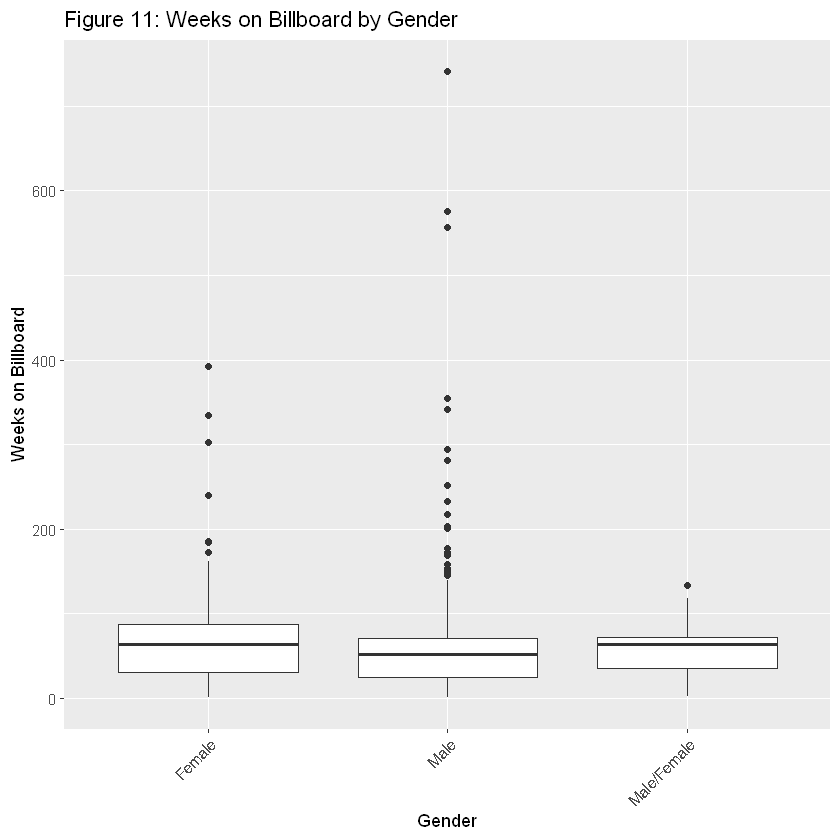

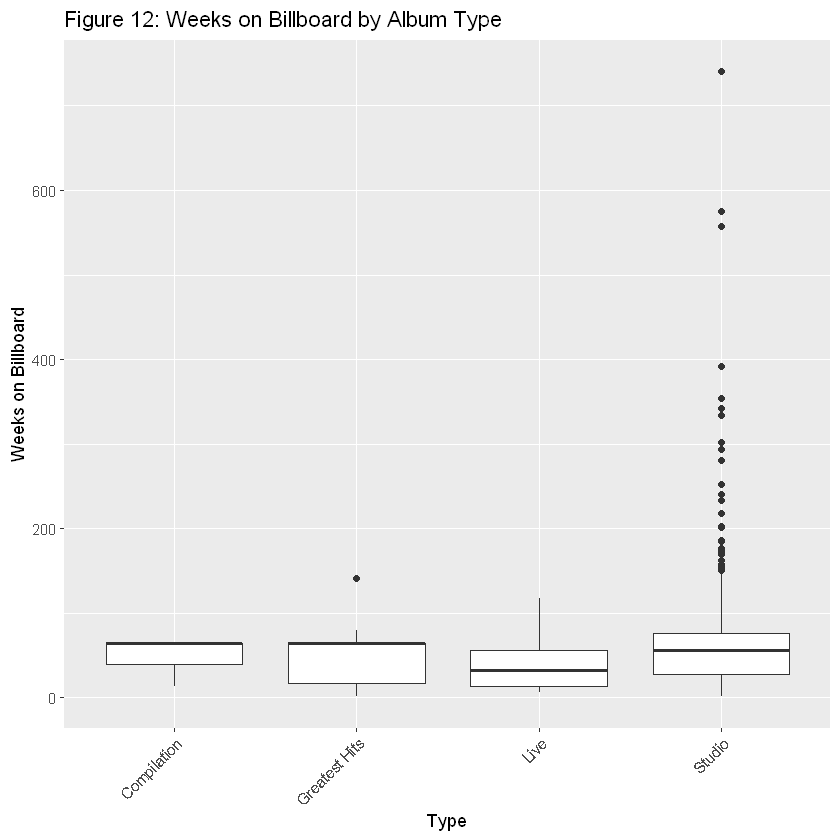

In [10]:
# Boxplot: weeks_on_billboard by genre
ggplot(train_data, aes(x = genre, y = weeks_on_billboard)) +
  geom_boxplot() +
  labs(title = "Figure 10: Weeks on Billboard by Genre", x = "Genre", y = "Weeks on Billboard") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
ggplot(train_data, aes(x = artist_gender, y = weeks_on_billboard)) +
  geom_boxplot() +
  labs(title = "Figure 11: Weeks on Billboard by Gender", x = "Gender", y = "Weeks on Billboard") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
ggplot(train_data, aes(x = type, y = weeks_on_billboard)) +
  geom_boxplot() +
  labs(title = "Figure 12: Weeks on Billboard by Album Type", x = "Type", y = "Weeks on Billboard") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability


## Predictor Selection

We selected predictors based on their correlation with the target variable (weeks_on_billboard) and their relevance to the problem. Predictors with an absolute correlation greater than 0.2 were considered strong candidates, while those with weaker correlations were excluded. The selected predictors are:

- release_year: Newer albums may have different chart longevity compared to older albums.

- peak_billboard_position: Albums that reach higher positions on the Billboard chart may stay on the chart longer.

- spotify_popularity: Albums with higher Spotify popularity may have greater commercial success and longer chart longevity.

- debut_album_release_year: The year an artist released their debut album may influence their album's performance on the chart.

- Predictors with weak correlations (e.g., differential, artist_member_count, artist_birth_year_sum, ave_age_at_top_500, years_between) were excluded to avoid overfitting and reduce model complexity.

In [9]:
library(caret)
# Drop irrelevant columns
cols_to_drop <- c("differential", "artist_member_count", "artist_birth_year_sum", 
                  "ave_age_at_top_500", "years_between")
train_data_cleaned <- train_data %>% select(-all_of(cols_to_drop))
test_data_cleaned <- test_data %>% select(-all_of(cols_to_drop))

# Define target column
target_col <- "weeks_on_billboard"

# Separate features and target
train_data_features <- train_data_cleaned %>% select(-all_of(target_col))
test_data_features <- test_data_cleaned %>% select(-all_of(target_col))

# Scale features
scaler <- preProcess(train_data_features, method = c("range"))
train_data_features_scaled <- predict(scaler, train_data_features)
test_data_features_scaled <- predict(scaler, test_data_features)

# Check levels of categorical variables in the training and testing sets
train_levels <- unique(train_data_features_scaled$type)
test_levels <- unique(test_data_features_scaled$type)

# Find new levels in the testing set
new_levels <- setdiff(test_levels, train_levels)


# Remove rows with new levels from the testing set
test_data_final <- test_data_features_scaled %>%
  filter(!type %in% new_levels)

# Filter the target column to match the filtered features
test_data_target_filtered <- test_data_cleaned[[target_col]][!test_data_features_scaled$type %in% new_levels]

# Combine scaled features with the filtered target column
test_data_final <- cbind(test_data_final, target = test_data_target_filtered)

# Combine scaled features with the target in the final training data
train_data_final <- cbind(train_data_features_scaled, target = train_data_cleaned[[target_col]])

# Check the final datasets
head(train_data_final)
head(test_data_final)

ERROR: Error in library(caret): there is no package called 'caret'


In [ ]:
# Define the formula
formula <- as.formula("target ~ .")

# Define the tuning grid for k (number of neighbors)
tune_grid <- expand.grid(k = seq(1, 20, by = 1))  # Test k values from 1 to 20

# Set up cross-validation
ctrl <- trainControl(method = "cv", number = 5)  # 5-fold cross-validation

# Train the kNN model with custom metric
knn_model <- train(
  formula,
  data = train_data_final,
  method = "knn",
  tuneGrid = tune_grid,
  trControl = ctrl,
  metric = "RMSE",  # Use RMSE as the primary metric (required by caret)
  maximize = FALSE,  # Minimize RMSE
  # Custom function to calculate Adjusted R-squared
  custom = list(
    summaryFunction = function(data, lev = NULL, model = NULL) {
      n <- nrow(data)
      p <- length(model$finalModel$xNames)
      adj_r2 <- adjusted_r2(data$obs, data$pred, n, p)
      out <- c(adj_r2 = adj_r2)
      return(out)
    }
  )
)

# View the model
print(knn_model)

In [ ]:
# Make predictions on the testing set
predictions <- predict(knn_model, newdata = test_data_final)
# Calculate RMSE
rmse <- sqrt(mean((test_data_final$target - predictions)^2))
print(paste("RMSE on Testing Set:", rmse))

# Calculate R-squared
ss_total <- sum((test_data_final$target - mean(test_data_final$target))^2)
ss_residual <- sum((test_data_final$target - predictions)^2)
r2 <- 1 - (ss_residual / ss_total)
print(paste("R-squared on Testing Set:", r2))

## Discussion:
Our interpretation of the data:
The correlations between the predictors and the weeks on the billboard were generally weak. The variable that correlated with the weeks on the billboard most was the spotify popularity, which is expected since both are direct measurements of the popularity of the album. The correlation was 0.35723461. The variable that correlated with the weeks on the billboard the least was the years between the release date of the album and the first album the artist released. This was a bit surprising since people might expect more experienced artists to make more popular works. The correlaton was -0.04631483.

Implications of the data:
The data could be used to predict the peak productivity of artists and determine which artists show the most promise in regard to their future career opportunities. Our data seems to imply that artists peak early in their careers. This may imply that the conditions required to produce popular music are mainly circumstantial and are difficult to recreate. This may raise future questions such as whether hiring based on experience is a good practice in some industries.

## References:
at least 4 citations relevant to the project (format is your choose, just be consistent across the references).

In [ ]:
https://globalnews.ca/news/8540223/old-music-more-popular-than-new-songs/
https://theboar.org/2022/01/why-do-artistspeak-early/
https://kaitlinbove.com/what-is-popular-music
https://www.statista.com/chart/15763/most-popular-music-genres-worldwide/